In [79]:
import json

import nltk
from nltk import stem
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from tqdm.notebook import tqdm

from pan20 import fake, util
from pan20.util import lexicons, text

In [2]:
df = fake.load()
df['toks'] = df.tweet.apply(text.tokenize)

In [36]:
with open('data/fake/al.json') as f:
    lex = json.loads(f.read())['w'][0:1000]
stems = []
for l in lex:
    stems.append(ps.stem(l))
lex += stems
lex = list(set(stems))

In [134]:
def anger_score(toks):
    n = len(toks)
    c = sum(1 for t in toks 
            if t in lex2
            or ps.stem(t) in lex2)
    return c / n

df['anger'] = df.toks.apply(anger_score)

In [133]:
lex2 = [l for l in lex if l not in ['donald', 'trump', 'obama']]

In [136]:
with open('data/fake/lex2.json', 'w+') as f:
    f.write(json.dumps({'stems': lex2}))

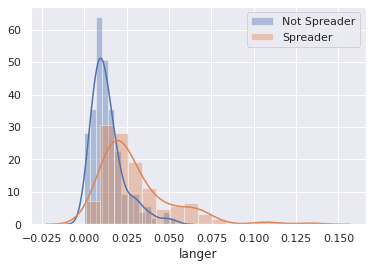

In [135]:
dfg = df.groupby(['author', 'label']).mean().reset_index()
_ = sns.distplot(dfg[dfg.label == False].langer, label='Not Spreader')
_ = sns.distplot(dfg[dfg.label == True].langer, label='Spreader')
plt.legend()
plt.show()

LIWC has spreaders averaging 1 anger word per tweet, with non-spreaders mean close to zero. Given the mean of 12 tokens per tweet, that is a frequency of around 0.08.

This plot at k=300, and looking at others for larger k, indicates:
- Too many non-anger words pulling non-spreader class up.
- Too few anger words in the set pushing spreaders forward.

Looks like we are ready to try and learn weights over the top-k to maximally separate the means of these groups.

In [49]:
vocab = util.IxDict(stems)

In [51]:
users = util.IxDict(df.author.unique())

In [69]:
# feature vectors
def get_vec(toks):
    vec = np.zeros((1, len(vocab)))
    stems = [ps.stem(t) for t in toks]
    for s in stems:
        if s not in vocab:
            continue
        ix = vocab[s]
        vec[0, ix] += 1
    vec /= len(toks)
    return vec

feats = []
labels = []
with tqdm(total=len(df.author.unique())) as pbar:
    for author in df.author.unique():
        aix = users[author]
        dfa = df[df.author == author]
        vecs = [get_vec(x.toks) for _, x in dfa.iterrows()]
        vecs = np.concatenate(vecs, axis=0)
        vec = np.expand_dims(vecs.mean(axis=0), 0)
        feats.append(vec)
        labels.append(dfa.iloc[0].label)
        pbar.update()
feats = np.concatenate(feats, axis=0)
labels = np.array(labels)

In [90]:
from sklearn import model_selection

skf = model_selection.StratifiedKFold(n_splits=5)
coef = []
accs = []
for tr_ix, ts_ix in skf.split(feats, labels):
    X_train, X_test = feats[tr_ix], feats[ts_ix]
    y_train, y_test = labels[tr_ix], labels[ts_ix]
    svc = svm.SVC(C=1., kernel='linear')
    svc.fit(X_train, y_train)
    tr_acc = metrics.accuracy_score(y_train, svc.predict(X_train))
    ts_acc = metrics.accuracy_score(y_test, svc.predict(X_test))
    coef.append(svc.coef_)
    print('----')
    print(tr_acc)
    print(ts_acc)
    accs.append(ts_acc)

----
0.6416666666666667
0.6
----
0.6333333333333333
0.5833333333333334
----
0.6416666666666667
0.55
----
0.6416666666666667
0.6666666666666666
----
0.6666666666666666
0.6333333333333333


In [91]:
np.mean(accs)

0.6066666666666667

In [93]:
coef = np.concatenate(coef, axis=0)

In [95]:
coef.mean(axis=0)

array([ 1.26003412e-03,  0.00000000e+00, -6.51329065e-03,  5.66434336e-03,
        0.00000000e+00, -4.02850845e-03,  9.29842391e-03,  7.81819603e-04,
       -5.01785796e-05,  5.05689596e-03,  2.77900197e-02,  4.73992674e-04,
        6.15384615e-04, -2.11558442e-03, -8.44137415e-02,  1.33333333e-03,
        0.00000000e+00,  1.13390466e-02,  2.71491597e-03, -4.82938459e-02,
        0.00000000e+00,  5.06128461e-02, -6.49548310e-02, -1.39876934e-01,
        2.87167652e-03, -2.37769398e-03, -1.23019386e-02,  0.00000000e+00,
       -2.51339086e-02,  0.00000000e+00,  0.00000000e+00, -6.92906107e-04,
       -2.88560120e-03, -7.43859709e-03, -2.06627326e-03,  1.03879320e-02,
       -1.87998104e-05, -9.12498393e-02,  0.00000000e+00,  1.40053993e-03,
        0.00000000e+00,  4.91080554e-02,  0.00000000e+00,  7.70308123e-05,
        0.00000000e+00,  4.48819345e-03,  2.85170118e-02,  1.26060606e-03,
       -2.63838384e-03,  2.17777778e-03, -2.28649158e-03, -1.17695237e-02,
        1.46240527e-03,  

In [96]:
rr2 = []
for ix, s in vocab.items():
    rr2.append({
        'stem': s,
        'mean': coef.mean(axis=0)[ix],
        'min': coef.min(axis=0)[ix],
        'max': coef.max(axis=0)[ix],
        'std': coef.std(axis=0)[ix],
    })
rr2 = pd.DataFrame(rr2)

In [97]:
rr2.head()

,stem,mean,min,max,std
0,abl,0.001260,0.000226,0.002213,0.000811
1,absolut,-0.006513,-0.011689,-0.002018,0.003278
2,abus,0.005664,-0.000226,0.021689,0.008168
3,action,-0.004029,-0.011991,0.003861,0.005431
4,administr,0.009298,0.001977,0.014887,0.004238


In [103]:
len(rr2)

565

In [104]:
len(rr2[rr2['max'] > 0])

414

In [105]:
dfl = rr2[rr2['max'] > 0]

In [111]:
dfl = dfl[dfl['mean'] > 0]

In [113]:
dfl['s'] = dfl['mean'] / dfl['std']

In [120]:
len(dfl[dfl['min'] < 0])

93

In [126]:
lex = list(dfl[(dfl['std'] < 0.001) & (dfl['min'] > 0)].stem.values)

In [129]:
lex = list(dfl[dfl.s > 5].stem.values)

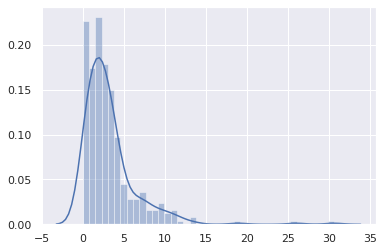

In [112]:
sns.distplot(dfl['mean'] / dfl['std'])

In [71]:
from sklearn import svm

svc = svm.SVC(C=1., kernel='linear')
svc.fit(feats, labels)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [72]:
help(svc)

Help on SVC in module sklearn.svm._classes object:

class SVC(sklearn.svm._base.BaseSVC)
 |  SVC(C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)
 |  
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`sklearn.svm.LinearSVC` or
 |  :class:`sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  ot

In [74]:
svc.coef_.shape

(1, 650)

In [75]:
from sklearn import metrics

metrics.accuracy_score(labels, svc.predict(feats))

0.6566666666666666

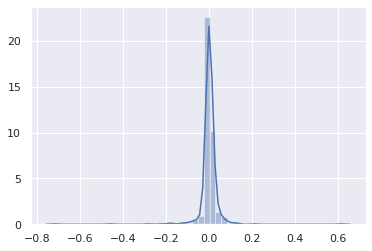

In [76]:
sns.distplot(svc.coef_)

In [80]:
rr = []
for ix, s in vocab.items():
    rr.append({
        'stem': s,
        'weight': svc.coef_[0, ix]
    })
rr = pd.DataFrame(rr)

In [82]:
sel = rr[rr.weight > 0]
len(sel)

322

In [84]:
sel.head(20)

,stem,weight
0,abl,0.001575
2,abus,0.007080
4,administr,0.011623
5,adult,0.000977
7,again,0.006321
8,against,0.034738
9,agenda,0.000592
10,aggrav,0.000769
13,allergi,0.001667
14,allow,0.014174


In [85]:
llex = list(sel.stem.values)

In [130]:
def anger_score2(toks):
    n = len(toks)
    ss = [ps.stem(t) for t in toks]
    c = sum(1 for s in ss if s in lex)
    return c / n

df['langer'] = df.toks.apply(anger_score2)

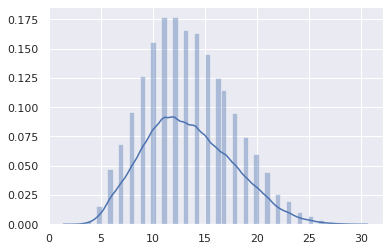

In [24]:
sns.distplot([len(x.toks) for _, x in df.iterrows()])

In [25]:
1 / 12

0.08333333333333333